The input of the NN is 1D. 

In [121]:
import numpy as np
import copy
import torch
import torch.nn as nn
import math
from torch.autograd import Variable
from torch.nn.functional import normalize
from sklearn.model_selection import train_test_split
from torch.nn.functional import normalize
import matplotlib.pyplot as plt

INPUT_SIZE = 1
OUTPUT_SIZE = 1

LAMBDA_PEN = 1000000
LOWER_BOUND = -6
UPPER_BOUND = 6
N_POINTS = 1001


def quad_fn(a, b, c, x):
    return a*x**2 + b*x + c

def x_square(x: torch.tensor) -> torch.Tensor:
    return x**2

# DEFINE GIVEN FUNCTION V(x): ax^2 + bx + c
given_fn = x_square

In [57]:
# CREATING DATASET:
x_values = [i for i in np.linspace(LOWER_BOUND, UPPER_BOUND, N_POINTS)]
y_values = [given_fn(i) for i in x_values]

x_train = np.array(x_values, dtype=np.float32).reshape(-1, 1)
y_train = np.array(y_values, dtype=np.float32).reshape(-1, 1)

print(x_train.shape, y_train.shape)

(1001, 1) (1001, 1)


In [73]:
# CUSTOM LOSS FUNCTION:
# def EpsilonLoss(nn.Module):

def epsilon_Loss(v_x, model_u, lower_bound, upper_bound, n_points):
    """
    GOAL: Epsilon function evaluated at u using discretized estimation
    minimizing Epsilon(u) = 
    
    ARGS: 
    n_points (int): number of discretized points on the interval [-L, L]
    e.g.: -(L)|---|---|---|---|(L) interval has n_points = 5

    v_x (torch.Tensor): function instance
    model_u (torch.Tensor): model output
    """
    sum = 0
    discrete_points = np.linspace(lower_bound, upper_bound, n_points)
    h = discrete_points[1] - discrete_points[0]
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        u_xi = model_u(x_i)

        u_prime = model_u.u_prime_2(x_i)
        
        v_xi = v_x(x_i)
        t = torch.square(u_prime) + v_xi*(u_xi**2)
        sum += t
        # print("x_i = " + str(x_i))
        # print("u_xi = " + str(u_xi))
        # print("u_prime = " + str(u_prime))
        # print("v_xi = " + str(v_xi))
        # print(t)
        # print('-----')
    return 0.5*h*sum

def epsilon_Loss_penalty(v_x, model_u, lambda_pen,
                         lower_bound, upper_bound, n_points):
    """
    
    """
    sum = 0
    pen = 0

    discrete_points = np.linspace(lower_bound, upper_bound, n_points)
    h = discrete_points[1] - discrete_points[0]
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        u_xi = model_u(x_i)

        u_prime = model_u.u_prime_2(x_i)
        
        v_xi = v_x(x_i)
        t = torch.square(u_prime) + v_xi*(u_xi**2)
        sum += t
    epsilon_fn = 0.5*h*sum
    
    temp = 0
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        temp += torch.square(model_u(x_i))
    
    pen = lambda_pen * torch.square((temp*h-1))
    return epsilon_fn + pen 

# NORMALIZE MODEL u(x) OUTPUT:
def normalize_u(model_u, lower_bound, upper_bound, n_points):
    """
    Normalize model.output weight by: 
    model.output *= c
    where,
    scalar c = 1/denom
    """
    discrete_points = np.linspace(lower_bound, upper_bound, n_points)
    h = discrete_points[1] - discrete_points[0]
    s = 0
    for i in discrete_points:
        x_i = torch.tensor([i], requires_grad=True, dtype=torch.float)
        t = model_u(x_i)**2
        s += t
    denom = math.sqrt(h) * torch.sqrt(s)
    return 1/denom

In [91]:
# CREATING MODEL CLASS
class Nonlinear(nn.Module):
    def __init__(self, n):
        # One hidden layer with n nodes
        super().__init__()
        self.hidden = nn.Linear(1, n)
        self.output = nn.Linear(n, 1)
        
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        self.target_fn = given_fn

    def forward(self, x, use_tanh_fn = False, activation_on_output = False):
        if use_tanh_fn == True:
            x = self.hidden(x)
            x = self.tanh(x)
            x = self.output(x)
            
        else:
            x = self.hidden(x)
            x = self.sigmoid(x)
            x = self.output(x)
            
        if activation_on_output == False:
            return x
        else:
            if use_tanh_fn == True:
                return self.tanh(x)
            else:       
                return self.sigmoid(x)
        # output is a linear combination of the hidden layers because 
        # we perform regression ???
        return x

    def u_prime_2(self, input):
        i_clone = input.clone()
        clone = copy.deepcopy(self)
        res = clone(i_clone).backward()
        return i_clone.clone()

    def u_prime(self, input):
        """
        NN with 1 hidden node layer is of the form:
        u(x) = SUM_i_to_N(a_i * sigmoid(w.x + b))

        where
        a_i is the corresponding weight of self.output layerq
        w is self.hidden.weight vector
        b is self.hidden.bias vector
        sigmoid(w.x + b) is the sigmoid-activated hidden vector

        Formula of u'(x) (for 1 hidden layer NN):
        u'(x) = SUM_i_to_N(w_i*a_i*sigmoid'(w_i*x+b))
        Note: sigmoid'(w_i*x +b) = sigmoid(w_i*x+b)*(1-sigmoid(w_i*x+b))
        """
        a_i = self.output.weight.data
        w_i = torch.transpose(self.hidden.weight.data, 0, 1)
        wi_ai = w_i * a_i

        hid_layer = self.hidden(input)
        hid_layer_T = torch.reshape(hid_layer, (list(hid_layer.shape)[0], 1))
        m = hid_layer_T * (1-hid_layer_T)

        return wi_ai @ m
    
# TRANING MODEL
    def train_network_with_penalty(self, num_epochs, v_x, optimizer, lambda_pen,
                                    lower_bound, upper_bound, n_points):
        # For plotting loss value over epochs:
        x_epochs = []
        y_loss = []
        
        # stopping criterion:
        stop_counter = 0

        for epoch in range(num_epochs):
            optimizer.zero_grad()
            loss = epsilon_Loss_penalty(v_x, self, lambda_pen,
                                        lower_bound, upper_bound, n_points)
            y_loss.append(loss)
            x_epochs.append(epoch)
            #check if need to stop training:
            if epoch > 0 and stop_counter >= 5:
                c = normalize_u(self, lower_bound, upper_bound, n_points)
                self.output.weight.data.copy_(c.item() * self.output.weight.data)
                self.output.bias.data.copy_(c.item() * self.output.bias.data)
                print("c value = " + str(c))
                print("LOSS VALUE = " 
                      + str(epsilon_Loss(v_x, self, lower_bound, upper_bound, n_points)))
                break
            elif epoch > 0 and stop_counter < 5:
                if torch.abs(y_loss[epoch-1]-loss) <= 1e-5:
                    stop_counter += 1
                else:
                    stop_counter = 0

            print('epoch {}, loss {}'.format(epoch, loss.item()))
            loss.backward()
            # Calculate the derivative(loss) w.r.t the model's parameters
            adam_optimizer.step()

        return (x_epochs, y_loss)

In [130]:
l = epsilon_Loss(given_fn, model, 
                            LOWER_BOUND, UPPER_BOUND, N_POINTS)
l

tensor([78.7160], grad_fn=<MulBackward0>)

In [131]:
loss = epsilon_Loss_penalty(given_fn, model, LAMBDA_PEN, 
                            LOWER_BOUND, UPPER_BOUND, N_POINTS)
loss

tensor([78.7160], grad_fn=<AddBackward0>)

In [92]:
# DEFINE HYPER-PARAMETERS
batch_size = 50
learningRate = 0.05
num_epochs = 2000
# num_epochs = int(num_iters/(len(x_train)/batch_size))

#INIT PARAMETERS: 
# v_x = given_fn
l_b = -10
u_b = 10
n_points = 5

#INIT MODEL
model = Nonlinear(20)
if torch.cuda.is_available():
    model.cuda()

# INIT OPTIMIZER CLASS
# What is an optimizer: 
# SGD:
# SGD_optimizer = torch.optim.SGD(model.parameters(), lr=learningRate)
# Adam:
adam_optimizer = torch.optim.Adam(model.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)

# INIT LOSS FUNCTION: MSE
# criterion = epsilon_Loss

In [93]:
graph_val = model.train_network_with_penalty(num_epochs, given_fn, adam_optimizer, LAMBDA_PEN, LOWER_BOUND, UPPER_BOUND, N_POINTS)

epoch 0, loss 311638.4375
epoch 1, loss 115870.3203125
epoch 2, loss 28678496.0
epoch 3, loss 666085.75
epoch 4, loss 748461.5625
epoch 5, loss 396264.75
epoch 6, loss 615118.5625
epoch 7, loss 6818436.5
epoch 8, loss 10006583.0
epoch 9, loss 4798531.5
epoch 10, loss 729066.4375
epoch 11, loss 16824.146484375
epoch 12, loss 447408.21875
epoch 13, loss 792369.875
epoch 14, loss 821905.5625
epoch 15, loss 606870.0625
epoch 16, loss 282927.0625
epoch 17, loss 31810.541015625
epoch 18, loss 64147.80078125
epoch 19, loss 477790.15625
epoch 20, loss 1043489.8125
epoch 21, loss 1290062.25
epoch 22, loss 1016130.625
epoch 23, loss 505775.9375
epoch 24, loss 127561.359375
epoch 25, loss 1075.3262939453125
epoch 26, loss 51326.9921875
epoch 27, loss 170163.625
epoch 28, loss 289158.5
epoch 29, loss 379963.5
epoch 30, loss 436101.375
epoch 31, loss 459275.15625
epoch 32, loss 452779.40625
epoch 33, loss 419435.46875
epoch 34, loss 361859.21875
epoch 35, loss 283994.6875
epoch 36, loss 193340.9531

In [ ]:
epsilon_Loss(v_x, model, LOWER_BOUND, UPPER_BOUND, N_POINTS)

tensor([[345.6585]], grad_fn=<MulBackward0>)

In [110]:
loss_val = [i.detach().numpy().item() for i in graph_val[1]]

In [113]:
graph_val[0][270:]

[270, 271, 272, 273, 274]

<Figure size 432x288 with 0 Axes>

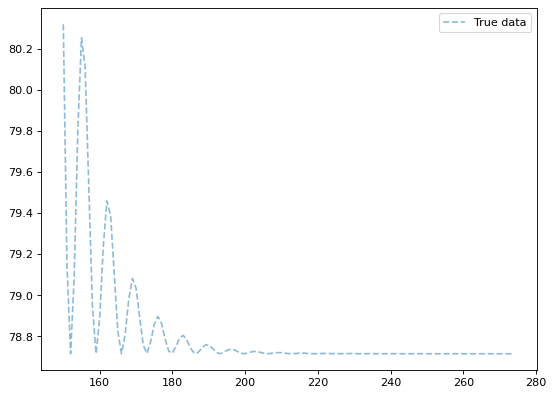

In [118]:
plot_figure(graph_val[0][150:], loss_val[150:])

Dear professor, here's my current progress:
1. I implement epsilon_Loss_penalty function. Now, the training process will iterate until it counts 5 consecutive times the loss difference between the current loss values with its previous loss < 1e-5. 

    Then, it finds the normalization constant c and apply to model.output weight layer and its bias. Then the algorithm updates the normalized output weight layer for the model. 

    The result: the training process only takes < 300 epochs to converge to a loss value of 78.7160. This occurs consistently after several re-runs. The problem: the constant c is 1 from my normalization function. I'm looking for a normalization from the PyTorch library to use instead. Please let me know if I can use this function for the normalization part: [PyTorch normalization function](https://pytorch.org/docs/stable/generated/torch.nn.functional.normalize.html)


In [117]:
# PLOT DATA
def plot_figure(x_train, y_train, x_test=None, predicted=None):
    plt.clf()
    plt.figure(figsize=(8, 6), dpi=80)
    plt.plot(x_train, y_train, '--', label='True data', alpha=0.5)
    if predicted != None:
        plt.plot(x_test, predicted, '--', label='Predictions', alpha=0.5)
    plt.legend(loc='best')
    plt.show()

<Figure size 432x288 with 0 Axes>

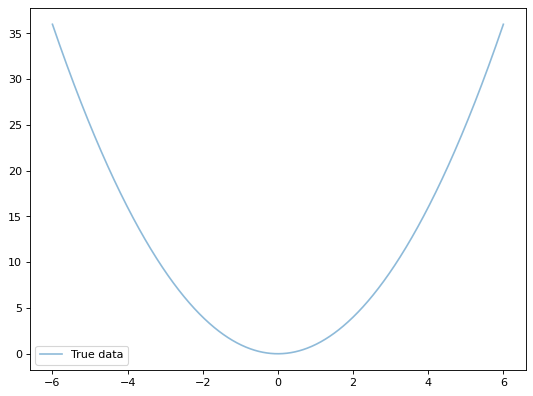

In [101]:
plot_figure(x_train, y_train)

# HOW TO TRAIN THE NN MODEL:
1. Reset adam_optimizer: 
```adam_opt.zero_grad()```
2. Calculate loss
3. Update the optimizer: 
```adam_opt.step()```


        weight = weight - lr * gradient

-> use lr and gradient to "improve" weight layer. 

Explanation:
```adam_opt.step()```: Update the model's parameters 


In [ ]:
model_p = Nonlinear_2(4)
adam_opt = torch.optim.Adam(model_p.parameters(), 
                                    lr=learningRate, 
                                    betas=(0.9, 0.999), 
                                    eps=1e-08, 
                                    weight_decay=0, 
                                    amsgrad=False)

In [ ]:
x_i = torch.tensor([-2.5], requires_grad=True, dtype=torch.float)
u_xi = model_p(x_i)
print(u_xi)
u_xi.backward()
u_prime = x_i.grad

tensor([-0.5799], grad_fn=<AddBackward0>)


In [ ]:
# Access the model's parameters:
# Model's hidden layer weight and bias
print("- Hidden layers: ")
print(model_p.hidden.weight)
print("\n")

print("- Hidden layers gradients (derivative of Loss w.r.t model params): ")
print(model_p.hidden.weight.grad)
print(model_p.hidden.bias)
print("\n")

# Model's output layer weight and bias
print("Output layers: ")
print(model_p.output.weight)
print(model_p.hidden.weight.grad)
print(model_p.output.bias)

# model.zero_grad()

i, o = (x_train[0], y_train[0])
i = Variable(torch.from_numpy(i))
o = Variable(torch.from_numpy(o))


- Hidden layers: 
Parameter containing:
tensor([[-0.4363],
        [-0.2556],
        [ 0.6323],
        [-0.8666]], requires_grad=True)


- Hidden layers gradients (derivative of Loss w.r.t model params): 
None
Parameter containing:
tensor([ 0.9463, -0.8034, -0.8181,  0.5812], requires_grad=True)


Output layers: 
Parameter containing:
tensor([[-0.3294, -0.3360,  0.0453, -0.0283]], requires_grad=True)
None
Parameter containing:
tensor([0.4850], requires_grad=True)


In [ ]:
import copy

model_pp = copy.deepcopy(model_p)
print(model_pp.hidden)
loss = epsilon_Loss(given_fn, model_pp, LOWER_BOUND, UPPER_BOUND, N_POINTS)
loss.backward()

Linear(in_features=1, out_features=4, bias=True)


RuntimeError: ignored

In [ ]:
model_pp.hidden.weight.grad

In [ ]:
loss.backward()

RuntimeError: ignored

In [ ]:
print("- Hidden layers: ")
print(model_p.hidden.weight)
print("\n")

print("- Hidden layers gradients (derivative of Loss w.r.t model params): ")
print(model_p.hidden.weight.grad)
print(model_p.hidden.bias)
print("\n")

# Model's output layer weight and bias
print("Output layers: ")
print(model_p.output.weight)
print(model_p.hidden.weight.grad)
print(model_p.output.bias)

# model.zero_grad()

i, o = (x_train[0], y_train[0])
i = Variable(torch.from_numpy(i))
o = Variable(torch.from_numpy(o))

- Hidden layers: 
Parameter containing:
tensor([[-0.4363],
        [-0.2556],
        [ 0.6323],
        [-0.8666]], requires_grad=True)


- Hidden layers gradients (derivative of Loss w.r.t model params): 
None
Parameter containing:
tensor([ 0.9463, -0.8034, -0.8181,  0.5812], requires_grad=True)


Output layers: 
Parameter containing:
tensor([[-0.3294, -0.3360,  0.0453, -0.0283]], requires_grad=True)
None
Parameter containing:
tensor([0.4850], requires_grad=True)


In [ ]:
x.grad.zero_()

tensor([0., 0., 0.])

In [ ]:
a = torch.tensor([2., 3.], requires_grad=True)
b = torch.tensor([6., 4.], requires_grad=True)

t = 3*a**3 - b**2

external_grad = torch.tensor([1., 1.])
t.backward(gradient=external_grad)

print(9*a**2 == a.grad)
print(-2*b == b.grad)

tensor([True, True])
tensor([True, True])


https://neptune.ai/blog/pytorch-loss-functions
https://stackoverflow.com/questions/53980031/pytorch-custom-loss-function
https://stackoverflow.com/questions/65947284/loss-with-custom-backward-function-in-pytorch-exploding-loss-in-simple-mse-exa
https://www.youtube.com/watch?v=ma2KXWblllc